# Import Libaries and Data

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

## Label Encode Categorical Columns

In [3]:
# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

# Create mean weather cols

In [4]:
df['temp_mean']=df.filter(regex='temp').mean(axis=1)
df['dew_point_mean']=df.filter(regex='dew_point').mean(axis=1)
df['humidities_mean']=df.filter(regex='humidities').mean(axis=1)
df['dew_point_mean']=df.filter(regex='dew_point').mean(axis=1)
df['wind_speeds_mean']=df.filter(regex='wind_speeds').mean(axis=1)
df['pressures_mean']=df.filter(regex='pressures').mean(axis=1)

## Multicolinearity

In [5]:
# Create correlation matrix
corr = df.drop(columns='price_tomorrow').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_price = df.corr()['price_tomorrow'].reset_index().sort_values('price_tomorrow', ascending=False)

# Rename correlation column
corr.rename(columns={0:'cor'}, inplace=True)

# Remove correlation between same variables and duplicates
corr = corr.loc[corr['cor']!=1]
corr.drop_duplicates(subset='cor', inplace=True)
corr_price = corr_price.loc[corr_price['price_tomorrow']!=1]

# Reset index
corr.reset_index(drop=True, inplace=True)
corr_price.reset_index(drop=True, inplace=True)

# Round
corr.cor =corr.cor.apply(lambda x: round(x,3))

In [6]:
corr.head(50)

,level_0,level_1,cor
0,temp_mean,temp_madrid,0.964
1,temp_barcelona,temp_mean,0.948
2,temp_valencia,temp_mean,0.942
3,temp_valencia,temp_barcelona,0.919
4,solar_forecast_tomorrow,generation solar,0.918
5,dew_point_mean,dew_point_barcelona,0.916
6,dew_point_valencia,dew_point_mean,0.911
7,temp_barcelona,temp_madrid,0.907
8,temp_madrid,temp_valencia,0.898
9,temp_bilbao,temp_mean,0.880


Get the pairs of variables highly correlated with each other, and for each pair, drop the one with the lower correlation with `price_tomorrow`

In [9]:
drop = []
for row in range(len(corr.loc[corr.cor>.8])):
    var1 = corr.loc[row,'level_0']
    var2 = corr.loc[row,'level_1']
    
    # Get var corrs with price_tomorrow
    var1_corr = float(corr_price.loc[corr_price['index'] == var1, 'price_tomorrow'])
    var2_corr = float(corr_price.loc[corr_price['index'] == var2, 'price_tomorrow'])
    
    # Add the lower correlation to the drop list
    if var1_corr > var2_corr:
        drop.append(var2)
    else:
        drop.append(var1)

Drop highly correlated weather columns

In [10]:
df.drop(columns=drop, inplace=True)

In [11]:
# Create correlation matrix
corr = df.drop(columns='price_tomorrow').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_price = df.corr()['price_tomorrow'].reset_index().sort_values('price_tomorrow', ascending=False)

# Rename correlation column
corr.rename(columns={0:'cor'}, inplace=True)

# Remove correlation between same variables and duplicates
corr = corr.loc[corr['cor']!=1]
corr.drop_duplicates(subset='cor', inplace=True)
corr_price = corr_price.loc[corr_price['price_tomorrow']!=1]

# Reset index
corr.reset_index(drop=True, inplace=True)
corr_price.reset_index(drop=True, inplace=True)

# Round
corr.cor =corr.cor.apply(lambda x: round(x,3))

In [12]:
corr_price

,index,price_tomorrow
0,price_today,0.950855
1,price_forecast_tomorrow,0.810115
2,generation biomass,0.285665
3,generation fossil gas,0.230432
4,generation other renewable,0.157231
5,load_forecast_tomorrow,0.127306
6,solar_forecast_tomorrow,0.111243
7,total load actual,0.107564
8,generation waste,0.097717
9,transmission_sp,0.078227


In [13]:
corr.head(60)

,level_0,level_1,cor
0,price_forecast_tomorrow,price_today,0.790
1,wind_speeds_mean,wind_speeds_valencia,0.772
2,generation hydro pumped storage consumption,diff,0.768
3,dew_point_valencia,dew_point_bilbao,0.763
4,humidities_mean,humidities_valencia,0.727
5,wind_speeds_mean,wind_speeds_madrid,0.722
6,load_forecast_tomorrow,total load actual,0.714
7,transmission_sf,transmission_fs,0.661
8,wind_speeds_mean,wind_speeds_bilbao,0.638
9,generation hydro water reservoir,generation hydro run-of-river and poundage,0.629


In [14]:
import matplotlib.pyplot as plt

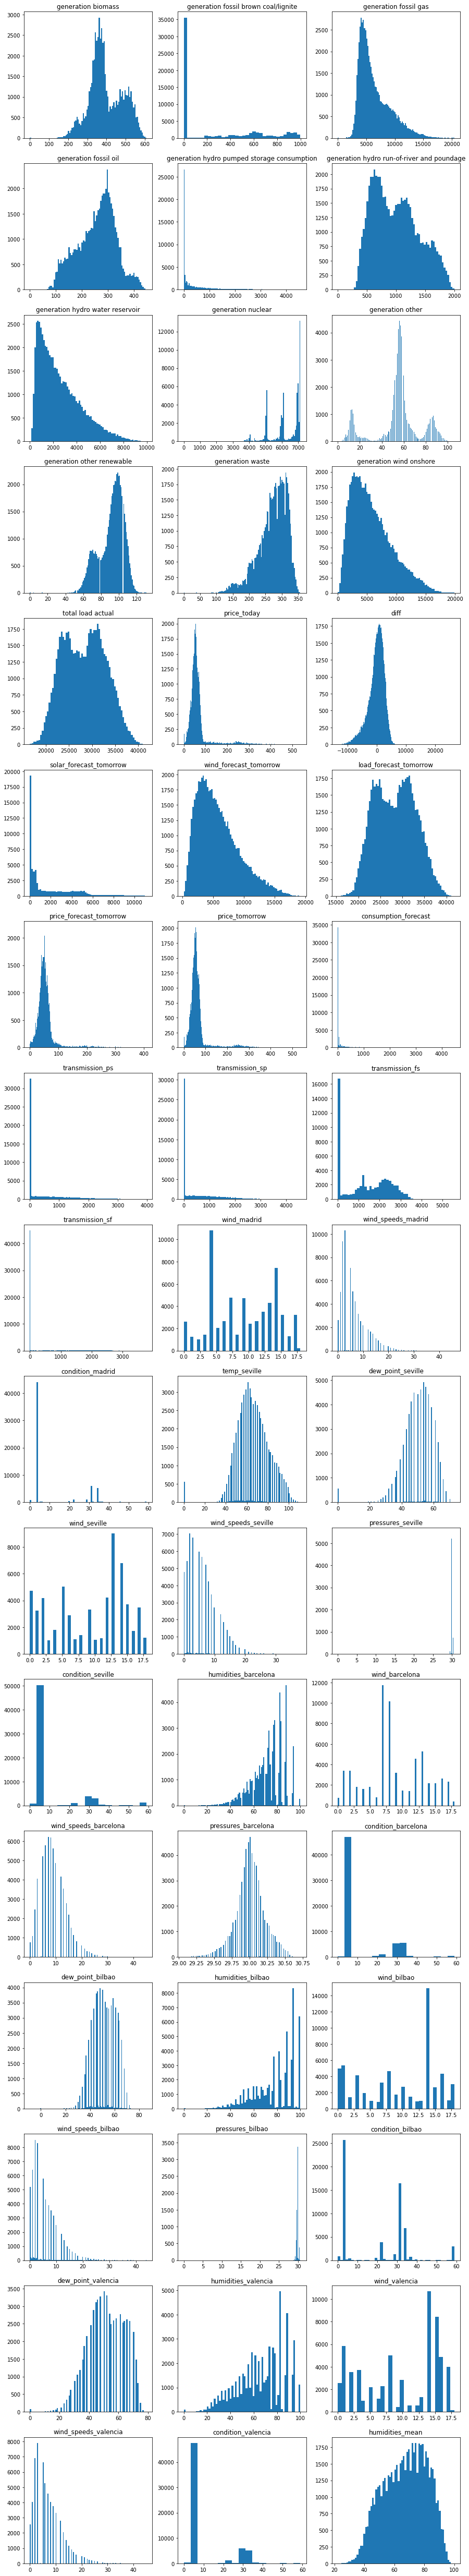

In [15]:
fig, axes = plt.subplots(nrows=df.shape[1]//3, ncols=3, figsize=(15,90));
for col, ax in zip(df.columns, axes.flatten()):
    ax.hist(df[col], bins='auto')
    ax.set_title(col)

## Split Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price_tomorrow'), df['price_tomorrow'], test_size=.3,
                                                    random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=17)

## Linear Regression

In [17]:
X_train = sm.add_constant(X_train)
lr_0 = sm.OLS(y_train, X_train).fit()
lr_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_tomorrow   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     9976.
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:52:50   Log-Likelihood:            -1.7698e+05
No. Observations:               42711   AIC:                         3.541e+05
Df Residuals:                   42660   BIC:                         3.545e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                         -22.8173     14.917     -1.530      0.126     -52.054       6.420
generation biomass                             -0.0075      0.001     -6.886      0.000      -0.010      -0.005
generation fossil brown coal/lignite            0.0022      0.000      5.237      0.000       0.001       0.003
generation fossil gas                           0.0002   6.73e-05      3.226      0.001    8.52e-05       0.000
generation fossil oil                          -0.0199      0.002    -11.982      0.000      -0.023      -0.017
generation hydro pumped storage consumption     0.0028      0.000      6.337      0.000       0.002       0.004
generation hydro run-of-river and poundage      0.0005      0.000      1.445      0.148      -0.000       0.001
generation hydro water reservoir                0.0004   9.16e-05      4.019      0.000       0.000       0.001
generation nuclear                              0.0002      0.000      1.670      0.095   -3.18e-05       0.000
generation other                                0.0407      0.005      8.592      0.000       0.031       0.050
generation other renewable                     -0.0908      0.008    -11.207      0.000      -0.107      -0.075
generation waste                               -0.0008      0.002     -0.341      0.733      -0.005       0.004
generation wind onshore                         0.0006   6.05e-05      9.174      0.000       0.000       0.001
total load actual                              -0.0005   6.46e-05     -8.459      0.000      -0.001      -0.000
price_today                                     0.8440      0.002    353.355      0.000       0.839       0.849
diff                                            0.0007      0.000      3.322      0.001       0.000       0.001
solar_forecast_tomorrow                         0.0002   6.58e-05      2.565      0.010    3.98e-05       0.000
wind_forecast_tomorrow                         -0.0004   2.81e-05    -12.801      0.000      -0.000      -0.000
load_forecast_tomorrow                          0.0004   2.68e-05     13.850      0.000       0.000       0.000
price_forecast_tomorrow                         0.2026      0.004     56.031      0.000       0.196       0.210
consumption_forecast                           -0.0013      0.000     -9.649      0.000      -0.002      -0.001
transmission_ps                              7.707e-05      0.000      0.320      0.749      -0.000       0.001
transmission_sp                                 0.0012      0.000      4.952      0.000       0.001       0.002
transmission_fs                                -0.0002      0.000     -1.022      0.307      -0.001       0.000
transmission_sf                                 0.0002     

## Feature Selection with RFE

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [19]:
r_squared = []
for i in range(1, len(X_train.columns)):
    lr_1 = LinearRegression()
    selector = RFE(lr_1, n_features_to_select=i)
    selector = selector.fit(X_train, y_train)
    cols = X_train.columns[selector.support_]
    lr_1.fit(X_train[cols], y_train)

    preds = lr_1.predict(X_val[cols])
    r_squared.append(r2_score(y_val, preds))

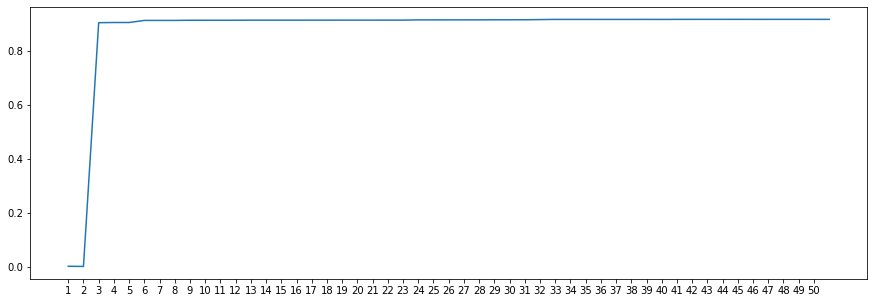

In [20]:
fig = plt.figure(figsize=(15,5))
plt.plot(range(1, len(X_train.columns)), r_squared);
plt.xticks(range(1,51));

After using on the first three most important features, linear regression begins to plateau.  We really don't achieve any better performance by adding the other features to the model. Now, I'll run a new model with only these three features.

In [21]:
lr_1 = LinearRegression()
selector = RFE(lr_1, n_features_to_select=3)
selector = selector.fit(X_train, y_train)
cols = X_train.columns[selector.support_]
lr_1.fit(X_train[cols], y_train)

LinearRegression()

In [22]:
# r2 score:
lr_1.score(X_val[cols], y_val)

0.9038432079636561

In [23]:
print(list(zip(X_val[cols],lr_1.coef_)))

[('price_today', 0.9527911347009198), ('pressures_barcelona', -5.772048473112134), ('pressures_bilbao', 2.4656038912416447)]


In [24]:
X_train_important = sm.add_constant(X_train[cols].copy())
lr_1 = sm.OLS(y_train, X_train_important).fit()
lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_tomorrow   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.377e+05
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:53:51   Log-Likelihood:            -1.8068e+05
No. Observations:               42711   AIC:                         3.614e+05
Df Residuals:                   42707   BIC:                         3.614e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 102.5281     11.718      8.750      0.000      79.561     125.495
price_today             0.9528      0.001    641.808      0.000       0.950       0.956
pressures_barcelona    -5.7720      0.488    -11.825      0.000      -6.729      -4.815
pressures_bilbao        2.4656      0.328      7.517      0.000       1.823       3.108
==============================================================================
Omnibus:                    14651.344   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4172860.106
Skew:                           0.308   Prob(JB):                         0.00
Kurtosis:                      51.419   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
df.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'diff', 'wind_forecast_tomorrow', 'load_forecast_tomorrow',
       'price_forecast_tomorrow', 'price_tomorrow', 'consumption_forecast',
       'transmission_ps', 'transmission_sp', 'transmission_fs',
       'transmission_sf', 'wind_madrid', 'wind_speeds_madrid',
       'condition_madrid', 'temp_seville', 'dew_point_seville', 'wind_seville',
       'wind_speeds_seville', 'pressures_seville', 'condition_seville',
       'humidities_barcelona', 'wind_barcelona', 'wind_speeds_barcelona',
       'pressures_barcelona', 'condition_barcelona', '

## Remove Price Actual

In [25]:
X_train = sm.add_constant(X_train)
lr_2 = sm.OLS(y_train, X_train.drop(columns='price_today')).fit()
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_tomorrow   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     1943.
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:54:04   Log-Likelihood:            -2.0619e+05
No. Observations:               42711   AIC:                         4.125e+05
Df Residuals:                   42661   BIC:                         4.129e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                        -243.4860     29.533     -8.245      0.000    -301.371    -185.601
generation biomass                              0.0041      0.002      1.886      0.059      -0.000       0.008
generation fossil brown coal/lignite            0.0024      0.001      2.794      0.005       0.001       0.004
generation fossil gas                           0.0005      0.000      3.727      0.000       0.000       0.001
generation fossil oil                          -0.0555      0.003    -16.873      0.000      -0.062      -0.049
generation hydro pumped storage consumption    -0.0018      0.001     -2.075      0.038      -0.004      -0.000
generation hydro run-of-river and poundage      0.0015      0.001      2.214      0.027       0.000       0.003
generation hydro water reservoir                0.0025      0.000     13.995      0.000       0.002       0.003
generation nuclear                             -0.0009      0.000     -4.269      0.000      -0.001      -0.001
generation other                                0.1073      0.009     11.454      0.000       0.089       0.126
generation other renewable                     -0.1744      0.016    -10.864      0.000      -0.206      -0.143
generation waste                                0.0174      0.005      3.831      0.000       0.008       0.026
generation wind onshore                         0.0009      0.000      7.638      0.000       0.001       0.001
total load actual                               0.0005      0.000      3.767      0.000       0.000       0.001
diff                                           -0.0012      0.000     -2.782      0.005      -0.002      -0.000
solar_forecast_tomorrow                         0.0023      0.000     17.609      0.000       0.002       0.003
wind_forecast_tomorrow                          0.0008   5.54e-05     14.300      0.000       0.001       0.001
load_forecast_tomorrow                         -0.0007   5.28e-05    -13.158      0.000      -0.001      -0.001
price_forecast_tomorrow                         1.1536      0.005    240.982      0.000       1.144       1.163
consumption_forecast                            0.0042      0.000     15.641      0.000       0.004       0.005
transmission_ps                                 0.0008      0.000      1.669      0.095      -0.000       0.002
transmission_sp                                -0.0020      0.000     -4.264      0.000      -0.003      -0.001
transmission_fs                                 0.0018      0.000      4.072      0.000       0.001       0.003
transmission_sf                                -0.0035      0.000     -7.279      0.000      -0.004      -0.003
wind_madrid                                    -0.0002     

## See what happens when add in features one by one

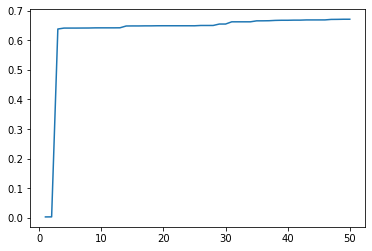

In [27]:
r_squared = []
for i in range(1, len(X_train.drop(columns='price_today').columns)):
    lr_2 = LinearRegression()
    selector = RFE(lr_2, n_features_to_select=i)
    selector = selector.fit(X_train.drop(columns='price_today'), y_train)
    cols = X_train.drop(columns='price_today').columns[selector.support_]
    lr_2.fit(X_train[cols], y_train)

    preds = lr_2.predict(X_val[cols])
    r_squared.append(r2_score(y_val, preds))
    
plt.plot(range(1, len(X_train.drop(columns='price_today').columns)), r_squared);

## Interactions

In [24]:
X_train.drop(columns='const', inplace=True)

In [25]:
X_rolling = X_train.rolling(window=7).mean()

In [26]:
X_rolling.columns.

SyntaxError: invalid syntax (<ipython-input-26-c39b10cf28e9>, line 1)

In [ ]:
my_list = ['a','b','c']
my_list.remove('a')
my_list

In [ ]:
X_rolling.columns

In [ ]:
x = [i for i in X_rolling.columns if i not in ['generation biomass']]

In [ ]:
X_rolling.columns

In [154]:
test = (X_rolling.columns.tolist()).remove('generation biomass')

In [155]:
test

In [134]:
list(X_rolling.columns).remove('generation biomass')

In [129]:
col = X_rolling.columns[0]
others = list(X_rolling.columns).remove(col)
for other in others:
    plt.plot(X_rolling[col], X_rolling[other])

TypeError: 'NoneType' object is not iterable

In [94]:
for col in X_rolling:
    

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil oil,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation waste,...,wind_speeds_bilbao,pressures_bilbao,condition_bilbao,dew_point_valencia,humidities_valencia,wind_valencia,wind_speeds_valencia,condition_valencia,humidities_mean,wind_speeds_mean
2016-05-27 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-08 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-18 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-24 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-29 09:00:00,406.571429,85.285714,9044.571429,228.000000,992.142857,2946.857143,6156.000000,62.857143,101.428571,270.000000,...,2.428571,30.011429,19.857143,47.285714,55.000000,10.285714,8.571429,8.285714,60.114286,6.485714
2018-10-14 06:00:00,388.142857,138.857143,8566.285714,232.714286,881.142857,2436.714286,6136.000000,64.000000,101.142857,272.000000,...,3.142857,29.935714,16.000000,47.000000,57.285714,10.000000,7.857143,12.142857,63.685714,6.514286
2020-04-20 06:00:00,388.714286,53.571429,8353.142857,213.714286,937.857143,2061.857143,6120.000000,61.571429,100.000000,263.857143,...,2.714286,29.894286,11.142857,45.857143,64.714286,12.285714,7.142857,12.142857,70.171429,6.371429
2018-12-27 15:00:00,393.142857,156.571429,9402.428571,221.285714,926.428571,2301.428571,5973.142857,62.142857,101.142857,271.428571,...,2.428571,29.865714,7.285714,49.714286,65.714286,11.571429,6.857143,12.142857,70.000000,5.628571


## Predict 24 hours at a time?

In [71]:
days = [str(day)[:10] for day in df.index.normalize().unique()]
df_2 = pd.DataFrame(index=df.index.normalize().unique(), columns = df.columns)

for day in days:
    for col in df_2.columns:
        df_2.loc[day, col] = list(df.loc[i,col].values)

ValueError: cannot copy sequence with size 24 to array axis with dimension 1

In [72]:
from tensorflow.keras.utils import timeseries_dataset_from_array

In [80]:
df.columns[-3]

'price tomorrow'

In [81]:
data = df.drop(columns='price_tomorrow').to_numpy()

In [84]:
target = df['price_tomorrow'].to_numpy()

In [96]:
dataset = timeseries_dataset_from_array(data, target, 24)

In [97]:
for batch in dataset:
    inputs, targets = batch

In [124]:
d_list =[]
enum = dataset.enumerate(start=0)
for element in enum.as_numpy_iterator():
    d_list.append(element[1])

In [156]:
d_list[0][0][127]

array([[5.46000000e+02, 9.37000000e+02, 4.86200000e+03, ...,
        4.00000000e+00, 9.72000000e+01, 5.60000000e+00],
       [5.46000000e+02, 9.59000000e+02, 5.14300000e+03, ...,
        4.00000000e+00, 9.24000000e+01, 4.80000000e+00],
       [5.44000000e+02, 9.80000000e+02, 4.84200000e+03, ...,
        4.00000000e+00, 9.38000000e+01, 5.20000000e+00],
       ...,
       [5.03000000e+02, 9.12000000e+02, 4.00100000e+03, ...,
        3.10000000e+01, 9.34000000e+01, 4.53333333e+00],
       [5.05000000e+02, 9.18000000e+02, 4.21900000e+03, ...,
        3.10000000e+01, 9.10000000e+01, 5.40000000e+00],
       [5.06000000e+02, 9.30000000e+02, 4.33800000e+03, ...,
        3.10000000e+01, 9.10000000e+01, 7.40000000e+00]])

In [164]:
df.iloc[:128]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil oil,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation waste,...,pressures_bilbao,condition_bilbao,dew_point_valencia,humidities_valencia,wind_valencia,wind_speeds_valencia,condition_valencia,price tomorrow,humidities_mean,wind_speeds_mean
2015-01-01 00:00:00,447.0,329.0,4844.0,162.0,1051.0,1899.0,7096.0,43.0,73.0,196.0,...,30.500000,59,37.0,87.0,17,3.0,4,64.02,82.200000,4.400000
2015-01-01 01:00:00,449.0,328.0,5196.0,158.0,1009.0,1658.0,7096.0,43.0,71.0,195.0,...,30.500000,59,37.0,93.0,16,3.0,4,58.46,83.400000,4.600000
2015-01-01 02:00:00,448.0,323.0,4857.0,157.0,973.0,1371.0,7099.0,43.0,73.0,196.0,...,30.500000,59,36.0,93.0,15,5.0,4,54.70,86.400000,4.066667
2015-01-01 03:00:00,438.0,254.0,4314.0,160.0,949.0,779.0,7098.0,43.0,75.0,191.0,...,30.500000,59,36.0,93.0,15,3.0,4,54.91,88.200000,3.533333
2015-01-01 04:00:00,428.0,187.0,4130.0,156.0,953.0,720.0,7097.0,43.0,74.0,189.0,...,30.500000,59,36.0,93.0,16,3.0,4,53.07,89.600000,4.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-06 03:00:00,532.0,784.0,4386.0,262.0,727.0,1834.0,4846.0,85.0,65.0,206.0,...,30.216667,59,43.0,100.0,17,3.0,6,62.11,94.733333,3.400000
2015-01-06 04:00:00,541.0,802.0,4453.0,266.0,727.0,1758.0,4895.0,85.0,66.0,206.0,...,30.213333,59,43.0,100.0,15,3.0,6,60.05,95.000000,3.400000
2015-01-06 05:00:00,545.0,856.0,4589.0,263.0,720.0,1793.0,4903.0,85.0,64.0,204.0,...,30.210000,31,39.0,100.0,15,3.0,29,62.48,96.000000,4.400000
2015-01-06 06:00:00,540.0,904.0,4818.0,257.0,720.0,1435.0,4911.0,85.0,63.0,202.0,...,30.210000,31,39.0,100.0,14,2.0,4,70.01,93.600000,6.000000


In [162]:
df.loc[df['generation biomass'] == 546]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil oil,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation waste,...,pressures_bilbao,condition_bilbao,dew_point_valencia,humidities_valencia,wind_valencia,wind_speeds_valencia,condition_valencia,price tomorrow,humidities_mean,wind_speeds_mean
2015-01-06 07:00:00,546.0,937.0,4862.0,283.0,779.0,2369.0,4924.0,85.0,63.0,184.0,...,30.210,31,37.0,100.0,14,2.0,4,75.20,97.2,5.600000
2015-01-06 08:00:00,546.0,959.0,5143.0,343.0,842.0,3860.0,4930.0,86.0,63.0,196.0,...,30.210,31,36.0,93.0,15,3.0,4,83.30,92.4,4.800000
2015-01-08 00:00:00,546.0,571.0,4178.0,383.0,658.0,831.0,6741.0,84.0,67.0,260.0,...,30.385,59,45.0,100.0,16,7.0,4,67.70,90.6,4.733333
2015-01-11 14:00:00,546.0,0.0,3789.0,213.0,640.0,681.0,5042.0,81.0,60.0,256.0,...,30.470,31,36.0,28.0,16,9.0,4,74.35,50.8,5.400000
2015-01-13 21:00:00,546.0,982.0,9945.0,345.0,1154.0,5030.0,7097.0,84.0,78.0,275.0,...,30.090,34,46.0,87.0,14,1.0,4,79.91,78.0,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-12 07:00:00,546.0,0.0,7439.0,136.0,1039.0,3028.0,5037.0,54.0,92.0,276.0,...,30.210,0,41.0,76.0,12,3.0,4,350.34,85.8,5.200000
2021-12-15 20:00:00,546.0,0.0,16670.0,182.0,1282.0,5257.0,5037.0,26.0,104.0,280.0,...,30.230,4,46.0,87.0,8,2.0,31,457.62,78.8,2.800000
2021-12-15 22:00:00,546.0,0.0,14960.0,179.0,1272.0,3360.0,5037.0,18.0,100.0,276.0,...,30.230,31,46.0,93.0,8,5.0,31,381.20,83.2,5.200000
2021-12-16 03:00:00,546.0,0.0,9989.0,170.0,1154.0,1622.0,5049.0,16.0,90.0,265.0,...,30.230,6,43.0,87.0,7,10.0,4,324.97,85.0,6.600000


In [147]:
inputs

<tf.Tensor: shape=(89, 24, 47), dtype=float64, numpy=
array([[[5.680e+02, 0.000e+00, 4.423e+03, ..., 4.000e+00, 9.100e+01,
         5.400e+00],
        [5.770e+02, 0.000e+00, 4.663e+03, ..., 4.000e+00, 9.100e+01,
         3.200e+00],
        [5.820e+02, 0.000e+00, 4.256e+03, ..., 4.000e+00, 8.560e+01,
         7.000e+00],
        ...,
        [5.330e+02, 0.000e+00, 3.431e+03, ..., 4.000e+00, 7.760e+01,
         1.140e+01],
        [5.240e+02, 0.000e+00, 3.392e+03, ..., 4.000e+00, 8.360e+01,
         8.200e+00],
        [5.380e+02, 0.000e+00, 3.688e+03, ..., 3.400e+01, 8.600e+01,
         1.020e+01]],

       [[5.770e+02, 0.000e+00, 4.663e+03, ..., 4.000e+00, 9.100e+01,
         3.200e+00],
        [5.820e+02, 0.000e+00, 4.256e+03, ..., 4.000e+00, 8.560e+01,
         7.000e+00],
        [5.830e+02, 0.000e+00, 4.686e+03, ..., 4.000e+00, 7.500e+01,
         7.600e+00],
        ...,
        [5.240e+02, 0.000e+00, 3.392e+03, ..., 4.000e+00, 8.360e+01,
         8.200e+00],
        [5.380e+02

In [112]:
df.loc['2021-12-29', 'price_tomorrow']

2021-12-29 00:00:00    262.60
2021-12-29 01:00:00    248.56
2021-12-29 02:00:00    240.45
2021-12-29 03:00:00    237.34
2021-12-29 04:00:00    236.89
2021-12-29 05:00:00    236.34
2021-12-29 06:00:00    252.62
2021-12-29 07:00:00    256.07
2021-12-29 08:00:00    297.98
2021-12-29 09:00:00    294.38
2021-12-29 10:00:00    268.43
2021-12-29 11:00:00    255.14
2021-12-29 12:00:00    255.59
2021-12-29 13:00:00    261.73
2021-12-29 14:00:00    248.92
2021-12-29 15:00:00    243.93
2021-12-29 16:00:00    257.96
2021-12-29 17:00:00    302.28
2021-12-29 18:00:00    343.42
2021-12-29 19:00:00    343.15
2021-12-29 20:00:00    339.64
2021-12-29 21:00:00    330.23
2021-12-29 22:00:00    276.32
2021-12-29 23:00:00    260.69
Name: price tomorrow, dtype: float64

In [93]:
array.shape

(61040, 48)

In [67]:
df_2.loc[days[0], 'generation biomass']

2015-01-01    NaN
Name: generation biomass, dtype: object

In [43]:
days = [str(date)[:10] for date in df.index]

In [63]:
days = [str(day)[:10] for day in df.index.normalize().unique()]
i = days[0]
col = 'generation biomass'
df.loc[i,col].values

array([447., 449., 448., 438., 428., 410., 401., 408., 413., 419., 422.,
       421., 428., 425., 423., 421., 422., 426., 427., 442., 445., 443.,
       440., 438.])

In [61]:
days

['2015-01-01',
 '2015-01-02',
 '2015-01-03',
 '2015-01-04',
 '2015-01-05',
 '2015-01-06',
 '2015-01-07',
 '2015-01-08',
 '2015-01-09',
 '2015-01-10',
 '2015-01-11',
 '2015-01-12',
 '2015-01-13',
 '2015-01-14',
 '2015-01-15',
 '2015-01-16',
 '2015-01-17',
 '2015-01-18',
 '2015-01-19',
 '2015-01-20',
 '2015-01-21',
 '2015-01-22',
 '2015-01-23',
 '2015-01-24',
 '2015-01-25',
 '2015-01-26',
 '2015-01-27',
 '2015-01-28',
 '2015-01-29',
 '2015-01-30',
 '2015-01-31',
 '2015-02-01',
 '2015-02-02',
 '2015-02-03',
 '2015-02-04',
 '2015-02-05',
 '2015-02-06',
 '2015-02-07',
 '2015-02-08',
 '2015-02-09',
 '2015-02-10',
 '2015-02-11',
 '2015-02-12',
 '2015-02-13',
 '2015-02-14',
 '2015-02-15',
 '2015-02-16',
 '2015-02-17',
 '2015-02-18',
 '2015-02-19',
 '2015-02-20',
 '2015-02-21',
 '2015-02-22',
 '2015-02-23',
 '2015-02-24',
 '2015-02-25',
 '2015-02-26',
 '2015-02-27',
 '2015-02-28',
 '2015-03-01',
 '2015-03-02',
 '2015-03-03',
 '2015-03-04',
 '2015-03-05',
 '2015-03-06',
 '2015-03-07',
 '2015-03-